In [2]:
import rasterio, os, glob, warnings, time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
plt.rcParams['font.size'] = 18
import seaborn as sns

import rioxarray as rx

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from sklearn.inspection import permutation_importance 

from sampling import *
from utils import *

warnings.filterwarnings("ignore")
plt.rcParams["figure.autolayout"] = True

In [3]:
# Input image paths
basepath = 'D:\Berkeley\Research\ExplainableWildfire\datasets'
os.chdir(basepath)

img_train = sorted(glob.glob('s2*.tif'))
dem_train = sorted(glob.glob('dem*.tif'))
slope_train = sorted(glob.glob('slope*.tif'))
aoi_train = sorted(glob.glob('fire*.tif'))
lulc_train = sorted(glob.glob('lulc*.tif'))

# Weather data
rmin_train = sorted(glob.glob('rmin*.tif'))
rmax_train = sorted(glob.glob('rmax*.tif'))
tmmn_train = sorted(glob.glob('tmmn*.tif'))
tmmx_train = sorted(glob.glob('tmmx*.tif'))
vs_train = sorted(glob.glob('vs*.tif'))


In [7]:
len(img_train)

37

In [8]:
img_train

['s2_aoi_ll00.tif',
 's2_aoi_ll01.tif',
 's2_aoi_ll04.tif',
 's2_aoi_ll05.tif',
 's2_aoi_ll08.tif',
 's2_aoi_ll09.tif',
 's2_aoi_ll10.tif',
 's2_aoi_ll11.tif',
 's2_aoi_ll16.tif',
 's2_aoi_ll19.tif',
 's2_aoi_ll20.tif',
 's2_aoi_ll22.tif',
 's2_aoi_ll23.tif',
 's2_aoi_ll24.tif',
 's2_aoi_ll25.tif',
 's2_aoi_ll26.tif',
 's2_aoi_ll27.tif',
 's2_aoi_ll28.tif',
 's2_aoi_ll29.tif',
 's2_aoi_ll30.tif',
 's2_aoi_ll31.tif',
 's2_aoi_ll32.tif',
 's2_aoi_ll33.tif',
 's2_aoi_ll34.tif',
 's2_aoi_ll35.tif',
 's2_aoi_ll36.tif',
 's2_aoi_ll37.tif',
 's2_aoi_ll39.tif',
 's2_aoi_ll41.tif',
 's2_aoi_ll42.tif',
 's2_aoi_ll43.tif',
 's2_aoi_ll44.tif',
 's2_aoi_ll45.tif',
 's2_aoi_ll46.tif',
 's2_aoi_ll48.tif',
 's2_aoi_ll49.tif',
 's2_aoi_ll50.tif']

In [4]:
number = 14

In [5]:
[x for x in paths(basepath)[2] if '04' in x]

['slope_aoi04_reproj.tif']

In [9]:
img_train, dem_train, slope_train, lulc_train, aoi_train = paths(basepath)

In [10]:
paths_df = pd.DataFrame(data={'s2':img_train, 'slope': slope_train, "lulc":lulc_train, 'aoi':aoi_train, 'dem': dem_train})
print('Number of fires:', paths_df.shape[0])
paths_df.head()

Number of fires: 37


,s2,slope,lulc,aoi,dem
0,s2_aoi_ll00.tif,slope_aoi00_reproj.tif,lulc_aoi00_reproj.tif,fire00_reproj.tif,dem_aoi00_reproj.tif
1,s2_aoi_ll01.tif,slope_aoi01_reproj.tif,lulc_aoi01_reproj.tif,fire01_reproj.tif,dem_aoi01_reproj.tif
2,s2_aoi_ll04.tif,slope_aoi04_reproj.tif,lulc_aoi04_reproj.tif,fire04_reproj.tif,dem_aoi04_reproj.tif
3,s2_aoi_ll05.tif,slope_aoi05_reproj.tif,lulc_aoi05_reproj.tif,fire05_reproj.tif,dem_aoi05_reproj.tif
4,s2_aoi_ll08.tif,slope_aoi08_reproj.tif,lulc_aoi08_reproj.tif,fire08_reproj.tif,dem_aoi08_reproj.tif


In [11]:
_ = paths_df.iloc[0]
_.head()

s2              s2_aoi_ll00.tif
slope    slope_aoi00_reproj.tif
lulc      lulc_aoi00_reproj.tif
aoi           fire00_reproj.tif
dem        dem_aoi00_reproj.tif
Name: 0, dtype: object

In [12]:
low_summary = pd.DataFrame(columns=['b', 'g', 'r', 'n',  'slope', 'dem', 'aspect'
, 'lulc', 'aoi', 'ndvi', 'savi'], index=np.arange(paths_df.shape[0]))

low_med_summary = pd.DataFrame(columns=['b', 'g', 'r', 'n',  'slope', 'dem', 'aspect'
, 'lulc', 'aoi', 'ndvi', 'savi'])

med_high_summary = pd.DataFrame(columns=['b', 'g', 'r', 'n',  'slope', 'dem', 'aspect'
, 'lulc', 'aoi', 'ndvi', 'savi'])

high_summary = pd.DataFrame(columns=['b', 'g', 'r', 'n',  'slope', 'dem', 'aspect'
, 'lulc', 'aoi', 'ndvi', 'savi'])

In [13]:
def io_rx(path):
    with rx.open_rasterio(path) as raster:
        img = raster.to_numpy()

        raster.close()
        
        return img

In [14]:
rx.open_rasterio(_['s2'])[0].to_numpy().shape

(2102, 4128)

Seperate image by band by severity

In [15]:
for idx in list(range(paths_df.shape[0])):

    _ = paths_df.iloc[idx]

    _s2_b = rx.open_rasterio(_['s2'])[0].to_numpy()
    _s2_g = rx.open_rasterio(_['s2'])[1].to_numpy()
    _s2_r = rx.open_rasterio(_['s2'])[2].to_numpy()
    _s2_n = rx.open_rasterio(_['s2'])[3].to_numpy()
    _slope = rx.open_rasterio(_['slope']).to_numpy()[0]
    _dem = rx.open_rasterio(_['dem']).to_numpy()[0]

    x, y = np.gradient(_dem)
    _aspect = np.arctan2(-x, y)

    _lulc = rx.open_rasterio(_['lulc']).to_numpy()[0]
    _aoi = rx.open_rasterio(_['aoi']).to_numpy()[0]

    _ndvi = (_s2_n/65535-_s2_r/65535)/(_s2_n/65535+_s2_r/65535)

    _savi = (_s2_n/65535-_s2_r/65535)/(_s2_n/65535+_s2_r/65535+0.5)*(1+0.5)

    low = np.where(_aoi==1, 1, 0)
    low_med = np.where(_aoi==2, 1, 0)
    med_high = np.where(_aoi==3, 1, 0)
    high = np.where(_aoi==4, 1, 0)

    low_list = []
    low_med_list = []
    med_high_list = []
    high_list = []

    for k in [_s2_b, _s2_g, _s2_r, _s2_n, _slope, _dem, _aspect, _lulc, _aoi, _ndvi, _savi]:
        low_arr = np.multiply(k, low).flatten()
        low_arr = low_arr[np.nonzero(low_arr)]
        low_list.append(low_arr)

        low_med_arr = np.multiply(k, low_med).flatten()
        low_med_arr = low_med_arr[np.nonzero(low_med_arr)]
        low_med_list.append(low_med_arr)

        med_high_arr = np.multiply(k, med_high).flatten()
        med_high_arr = med_high_arr[np.nonzero(med_high_arr)]
        med_high_list.append(med_high_arr)

        high_arr = np.multiply(k, high).flatten()
        high_arr = high_arr[np.nonzero(high_arr)]
        high_list.append(high_arr)

    low_summary.loc[idx] = low_list
    low_med_summary.loc[idx] = low_med_list
    med_high_summary.loc[idx] = med_high_list
    high_summary.loc[idx] = high_list


In [27]:
fire_numbers = [int(x.split('_')[0].split('fire')[-1]) for x in  aoi_train]
len(fire_numbers)

37

In [35]:
len(fire_numbers)

37

In [30]:
len(aoi_train)

37

In [32]:
aoi_train[-1]

'fire50_reproj.tif'

In [36]:
low_summary.shape

(37, 11)

In [31]:
low_med_summary.shape

(37, 11)

In [39]:
pd.DataFrame(data={'fire':fire_numbers,'low':low_summary['aoi'].apply(lambda x: len(x)), 'low med':low_med_summary['aoi'].apply(lambda x: len(x)), 
'med high':med_high_summary['aoi'].apply(lambda x: len(x)), 'high':high_summary['aoi'].apply(lambda x: len(x))}).to_csv(r'D:\GitHub\ExplainableFire\notebooks/fire_baer_summary.csv')

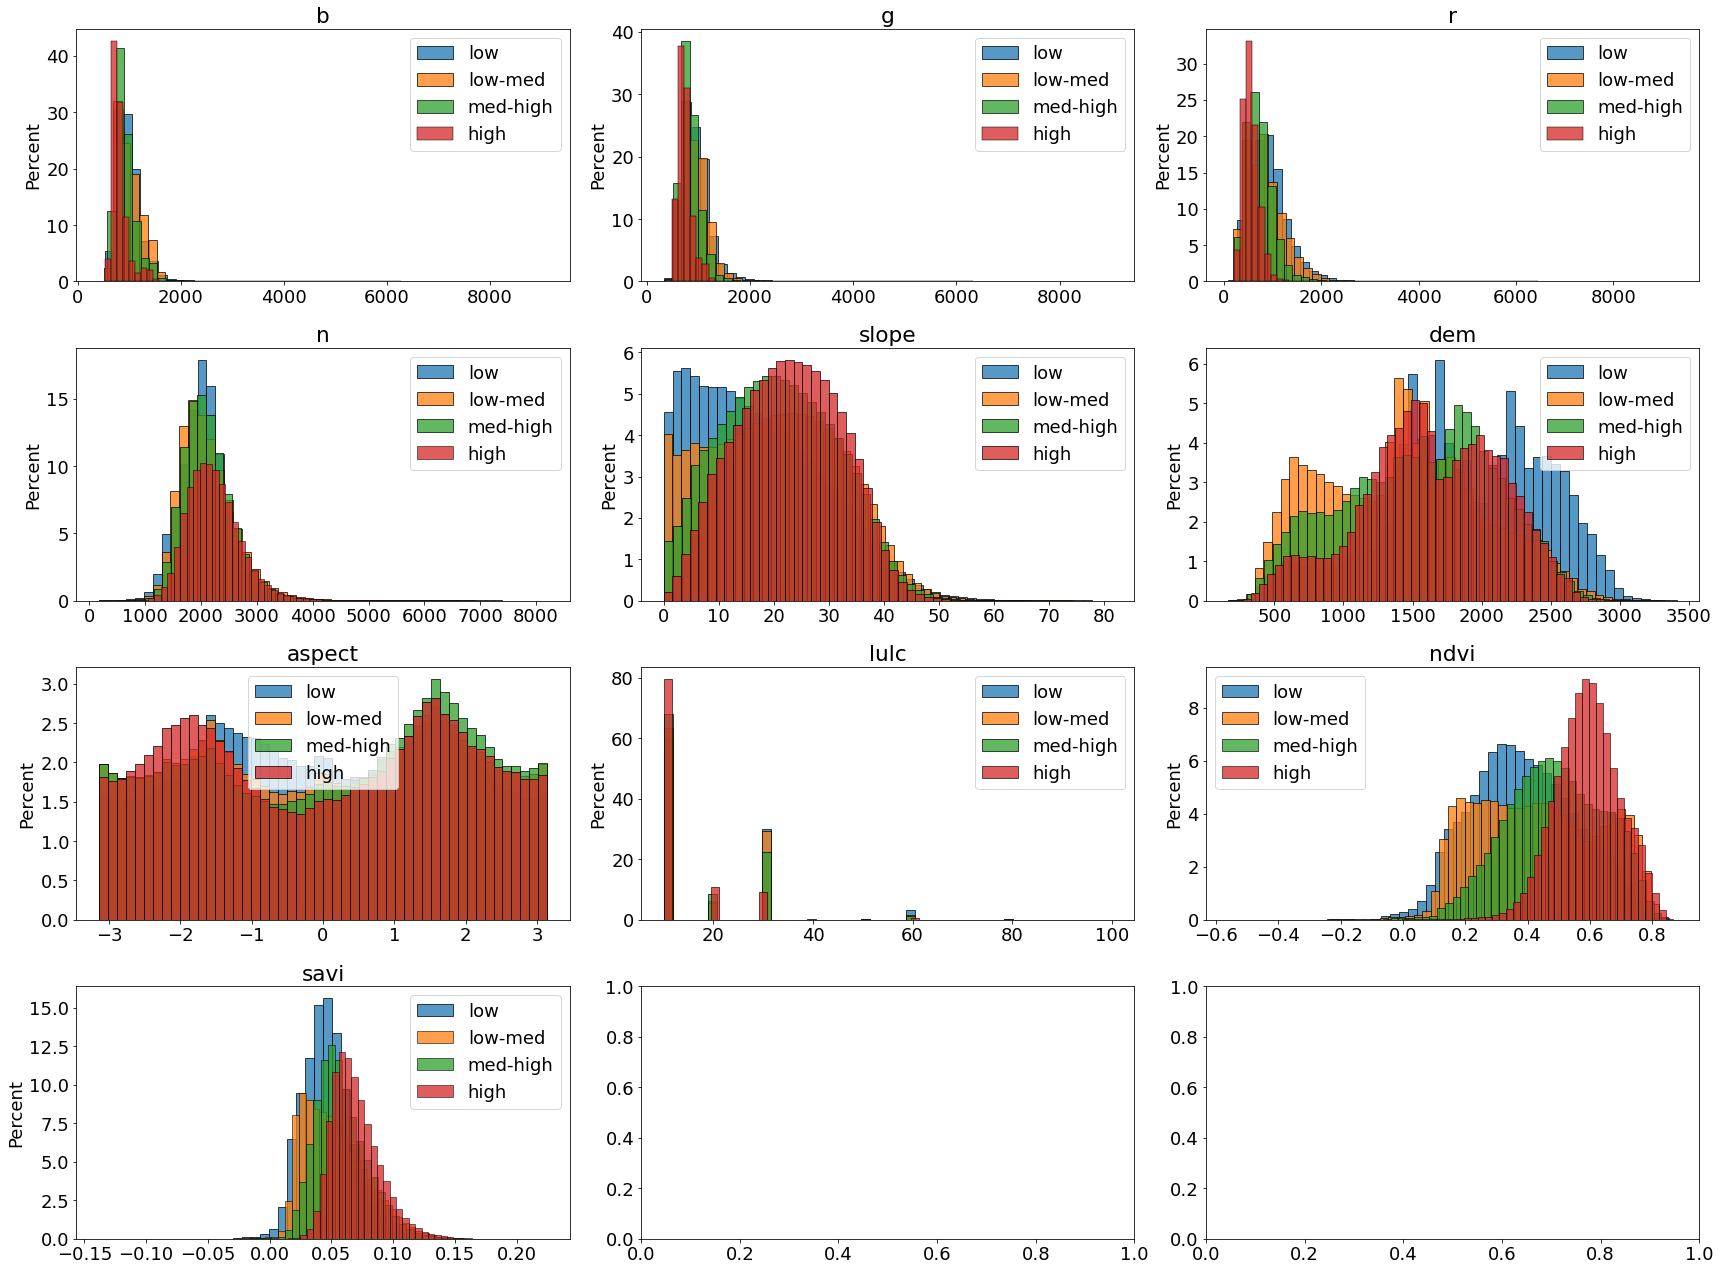

In [35]:
fig, ax = plt.subplots(4,3, figsize=[24,18])
bands = ['b', 'g', 'r', 'n',  'slope', 'dem', 'aspect', 'lulc', 'ndvi', 'savi']
ax = np.ravel(ax)

## plot distribution of band by severity
        
for index, band in enumerate(['b', 'g', 'r', 'n',  'slope', 'dem', 'aspect', 'lulc',  'ndvi', 'savi']):
    sns.histplot(np.concatenate(low_summary[band].to_numpy()), bins=50, stat='percent', ax=ax[index], label='low')
    sns.histplot(np.concatenate(low_med_summary[band].to_numpy()), bins=50, stat='percent', ax=ax[index], label='low-med')
    sns.histplot(np.concatenate(med_high_summary[band].to_numpy()), bins=50, stat='percent', ax=ax[index], label='med-high')
    sns.histplot(np.concatenate(high_summary[band].to_numpy()), bins=50, stat='percent', ax=ax[index], label='high')
    ax[index].set_title(band)
    ax[index].legend()

ax = np.reshape(ax, (4,3))
    